# Feature Extraction Training Data

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
%matplotlib inline

In [3]:
os.getcwd()

'/Users/daksh_mac/Desktop/SmartCleanCityHackZurich19-master'

In [4]:
%cd data

/Users/daksh_mac/Desktop/SmartCleanCityHackZurich19-master/data


## Load the Files

In [5]:
pred_msr = pd.read_csv("./2019-09-27-basel-measures-prediction-cleaned.csv", sep=";") 

In [6]:
msr = pd.read_csv("./2019-09-27-basel-measures-cleaned.csv", sep=";") 

In [7]:
print(msr.shape)
msr.head()

(58242, 17)


,collection,suitcase_id,place_name,place_type,osm_id,cci_id,date,cci,rateCigarrettes,ratePapers,rateBottles,rateExcrements,rateSyringues,rateGums,rateLeaves,rateGrits,rateGlassDebris
0,places,49,Leimgrubenweg,bus_stop,1175332462,287,2019-04-01 8:40:49,3.20000,0.60000,1.2,0.0,0,0,0,0.00000,0,0.0
1,map_features,49,Leimgrubenweg,secondary,25149740,86_9668,2019-04-01 8:40:53,3.35764,0.44236,1.2,0.0,0,0,0,0.00000,0,0.0
2,map_features,49,Reinacherstrasse,primary,117485263,86_11641,2019-04-01 8:40:53,3.35764,0.44236,1.2,0.0,0,0,0,0.00000,0,0.0
3,places,49,Leimgrubenweg,bus_stop,2621172927,287,2019-04-01 8:40:57,3.19757,0.60000,1.2,0.0,0,0,0,0.00243,0,0.0
4,map_features,49,Dornacherstrasse,secondary,148833576,86_12436,2019-04-01 8:42:11,5.00000,0.00000,0.0,0.0,0,0,0,0.00000,0,0.0


## Select Relevant Columns

In [8]:
msr_features = msr[['osm_id', 'cci_id', 'date', 'place_name', 'place_type', 'cci']].copy()

## Exclude rubbish types that are not feasible for pedestrians and calculate a new score: p_cci (pedestrian cci)

In [9]:
exclude = ['rateGrits', 'rateExcrements', 'rateSyringes', 'rateGlassDebris']

relevant = msr[[c for c in msr.columns if c.startswith('rate') and c not in exclude]]

relevant = relevant.astype('float')

msr_features['cci_p'] = relevant.apply(lambda x: 5.0 - sum(x), axis=1)

## Add features from datetime: hour, day, weekday, month and year

In [10]:
import datetime

def get_datefeat(date_str):
    a = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    weekday = a.weekday()
    month = a.month
    day = a.day
    hour = a.hour
    year = a.year
    
    return (hour, day, weekday, month, year)

datefeat = pd.DataFrame.from_records(msr_features.date.apply(lambda x: get_datefeat(x)).tolist(), columns=['hour', 'day', 'weekday', 'month', 'year'])

msr_features = msr_features.join(datefeat)

msr_features.head()

,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,day,weekday,month,year
0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,1,0,4,2019
1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,1,0,4,2019
2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,1,0,4,2019
3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,1,0,4,2019
4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,1,0,4,2019


### Plot hours when rubbish situation was recorded

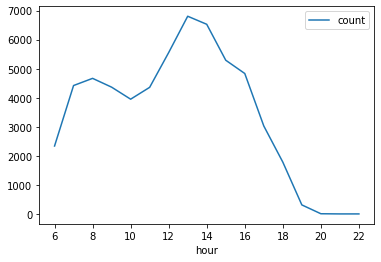

In [11]:
b = pd.DataFrame(msr_features.hour.value_counts()).reset_index().sort_values(by='index')

b.columns = ['hour', 'count']

b.plot(x='hour', y='count')

## Possible feature for future websearches (currently not used: German names for months and weekdays)

In [12]:
german_months = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September',
                10:'October', 11:'November', 12:'December'}

german_weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thurday',4:'Friday', 5:'Saturday', 6:'Sunday'}


msr_features['month_german'] = msr_features.month.apply(lambda x: german_months[x])
msr_features['weekday_german'] = msr_features.weekday.apply(lambda x: german_weekdays[x])



## Encode hours as daytimes: night, morning, afternoon, evening

In [13]:
def get_daytime(hour):
    if 0 <= hour < 6:
        return 'night'
    if 6 <= hour < 12:
        return 'morning'
    if 12 <= hour < 19:
        return 'afternoon'
    if 19 <= hour < 24:
        return 'evening'

msr_features['daytime'] = msr_features.hour.apply(lambda x: get_daytime(x))

In [14]:
msr_features.head()

,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,day,weekday,month,year,month_german,weekday_german,daytime
0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,1,0,4,2019,April,Monday,morning
1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,1,0,4,2019,April,Monday,morning
2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,1,0,4,2019,April,Monday,morning
3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,1,0,4,2019,April,Monday,morning
4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,1,0,4,2019,April,Monday,morning


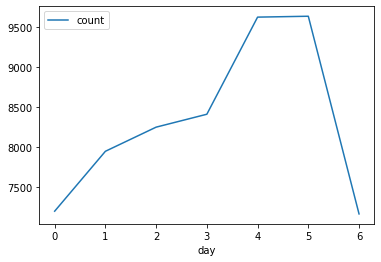

In [15]:
weekday_dist = pd.DataFrame(msr_features.weekday.value_counts()).reset_index()
weekday_dist.columns = ['day', 'count']

weekday_dist = weekday_dist.sort_values(by='day')

weekday_dist.plot(x='day', y='count')


## Save features to file

In [16]:
# save feature to file
msr_features.to_csv('2019-09-27-basel-measures-FEAT.csv', index=None)

In [19]:
msr_lastRead = pd.read_csv("2019-09-27-basel-measures-FEAT.csv") 

In [20]:
msr_lastRead.head()

,osm_id,cci_id,date,place_name,place_type,cci,cci_p,hour,day,weekday,month,year,month_german,weekday_german,daytime
0,1175332462,287,2019-04-01 8:40:49,Leimgrubenweg,bus_stop,3.20000,3.20000,8,1,0,4,2019,April,Monday,morning
1,25149740,86_9668,2019-04-01 8:40:53,Leimgrubenweg,secondary,3.35764,3.35764,8,1,0,4,2019,April,Monday,morning
2,117485263,86_11641,2019-04-01 8:40:53,Reinacherstrasse,primary,3.35764,3.35764,8,1,0,4,2019,April,Monday,morning
3,2621172927,287,2019-04-01 8:40:57,Leimgrubenweg,bus_stop,3.19757,3.19757,8,1,0,4,2019,April,Monday,morning
4,148833576,86_12436,2019-04-01 8:42:11,Dornacherstrasse,secondary,5.00000,5.00000,8,1,0,4,2019,April,Monday,morning
